In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import missingno as msno
import seaborn as sns
import gc
from catboost import CatBoostClassifier
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv').drop('id', axis=1)
test  = pd.read_csv('test.csv').drop('id', axis=1)
ss    = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.000000,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,NaN,0.054866,0.733289,0.835545,0.000996,8.000000,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,193213.000000,NaN,0.188387,0.783524,-0.002694,5.000000,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.000000,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,165969.000000,0.493017,NaN,0.740982,0.002033,10.000000,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [4]:
test.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,308523.000000,0.019845,NaN,0.908939,0.001438,NaN,0.112832,-8.890172,0,0.082714,126.129304,4,0.399620
1,200011.000000,0.070119,0.731256,0.444655,0.002020,10.000000,0.139040,-6.301214,0,0.061685,86.448149,3,0.499424
2,279758.000000,0.810637,0.568858,0.125466,0.898841,0.000000,0.226614,-11.542478,0,0.041868,99.544351,3,0.564951
3,249197.000000,NaN,0.871789,0.557342,0.000715,4.000000,0.325391,-7.905546,1,0.046815,123.063854,4,0.906485
4,NaN,0.765568,0.624687,0.710794,0.000346,8.000000,0.308284,NaN,0,0.129284,88.703121,3,0.935571


In [5]:
train.shape, test.shape

((40000, 14), (10000, 13))

Let's check for missing values

<AxesSubplot:>

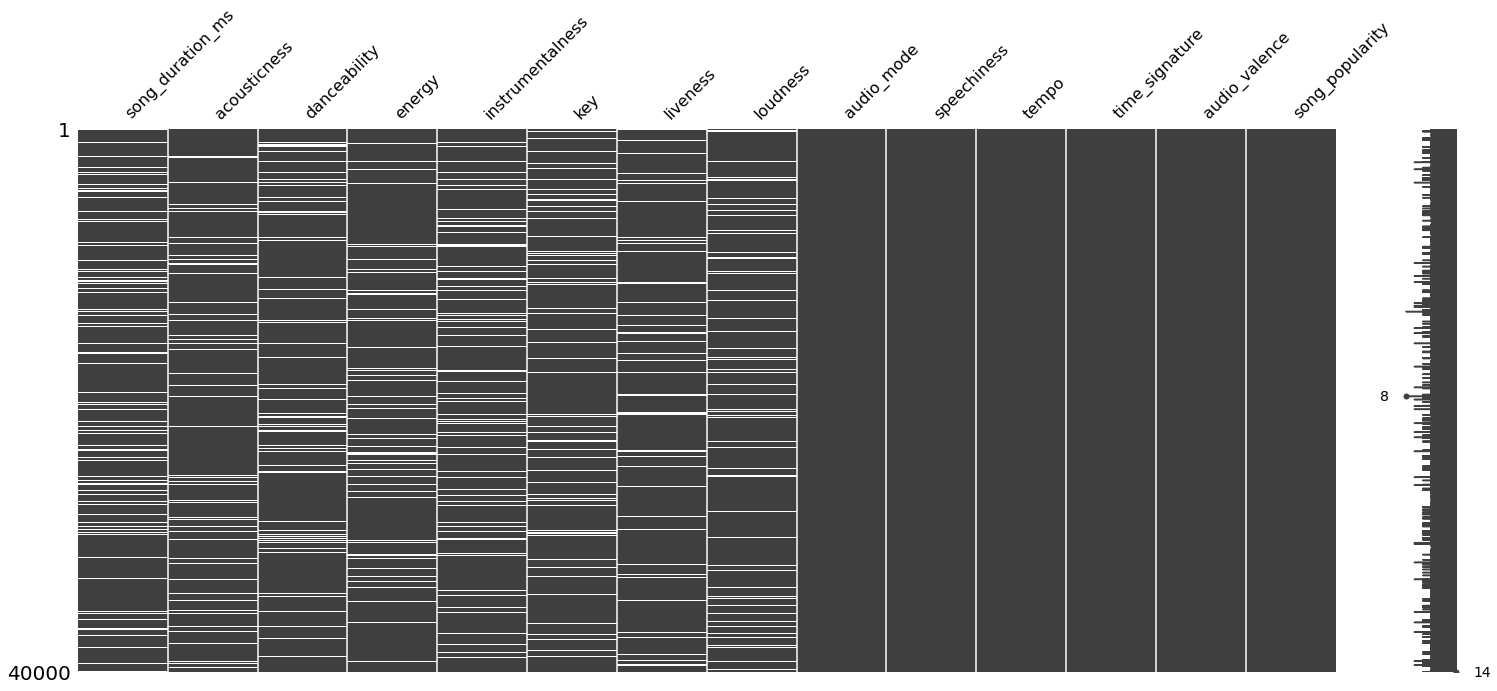

In [6]:
msno.matrix(train)

In [7]:
train.isnull().mean() * 100

song_duration_ms   10.252500
acousticness        9.980000
danceability       10.065000
energy              9.937500
instrumentalness    9.962500
key                10.162500
liveness           10.215000
loudness            9.892500
audio_mode          0.000000
speechiness         0.000000
tempo               0.000000
time_signature      0.000000
audio_valence       0.000000
song_popularity     0.000000
dtype: float64

<AxesSubplot:>

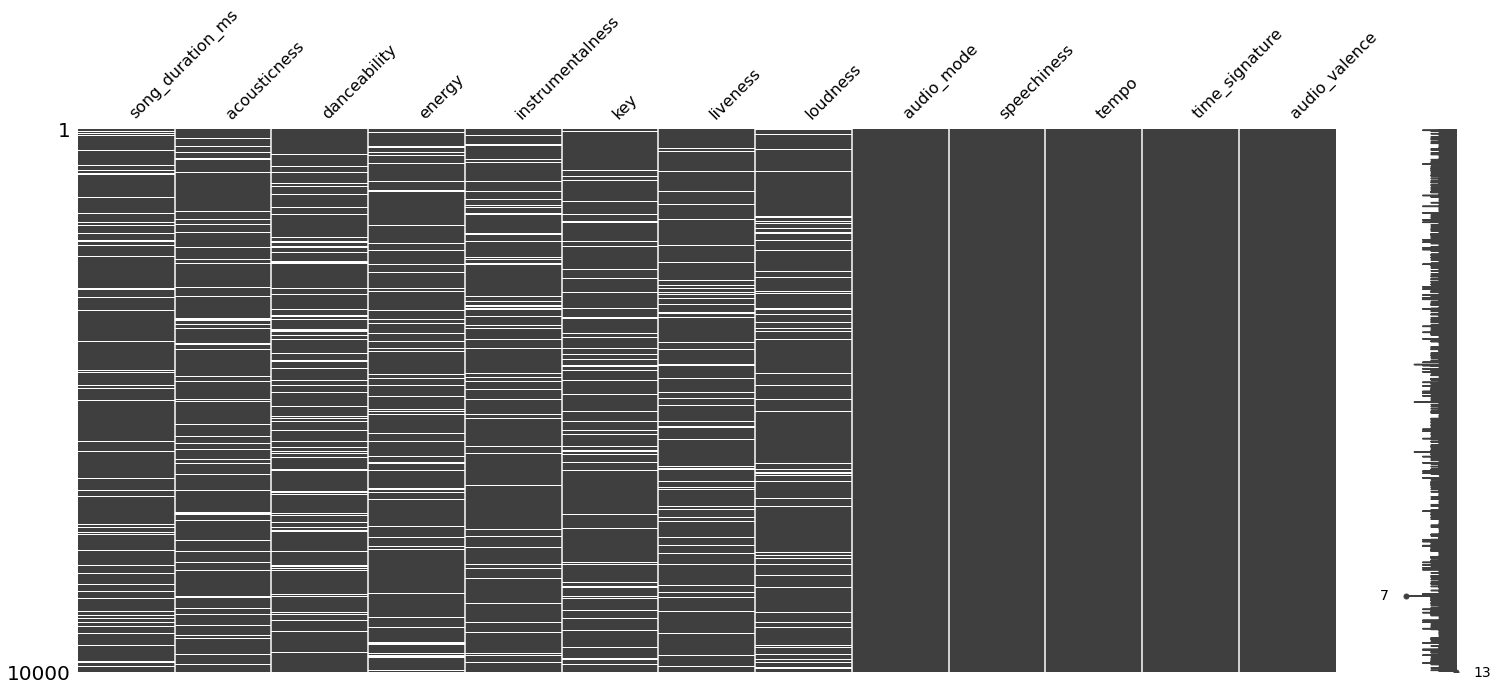

In [8]:
msno.matrix(test)

In [9]:
test.isnull().mean() * 100

song_duration_ms    9.570000
acousticness        9.500000
danceability        9.760000
energy             10.550000
instrumentalness   10.000000
key                 9.920000
liveness           10.060000
loudness           10.260000
audio_mode          0.000000
speechiness         0.000000
tempo               0.000000
time_signature      0.000000
audio_valence       0.000000
dtype: float64

In [10]:
train.loc[:, 'song_duration_ms':'audio_valence'].describe().T.style.bar(subset=['mean'], color='#206ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
song_duration_ms,35899.000000,193165.847572,45822.127679,25658.000000,166254.500000,186660.000000,215116.000000,491671.000000
acousticness,36008.000000,0.276404,0.297928,-0.013551,0.039618,0.140532,0.482499,1.065284
danceability,35974.000000,0.570951,0.190010,0.043961,0.424760,0.608234,0.718464,0.957131
energy,36025.000000,0.683932,0.212662,-0.001682,0.539276,0.704453,0.870503,1.039741
instrumentalness,36015.000000,0.036527,0.150024,-0.004398,0.000941,0.001974,0.003225,1.075415
key,35935.000000,5.042605,3.372728,0.000000,2.000000,5.000000,8.000000,11.000000
liveness,35914.000000,0.198514,0.151670,0.027843,0.111796,0.135945,0.212842,1.065298
loudness,36043.000000,-7.407596,3.877198,-32.117911,-9.578139,-6.345413,-4.620711,-0.877346
audio_mode,40000.000000,0.321150,0.466924,0.000000,0.000000,0.000000,1.000000,1.000000
speechiness,40000.000000,0.094107,0.083591,0.015065,0.038500,0.055881,0.118842,0.560748


Let's check the distribution on target in training data

<AxesSubplot:xlabel='song_popularity', ylabel='count'>

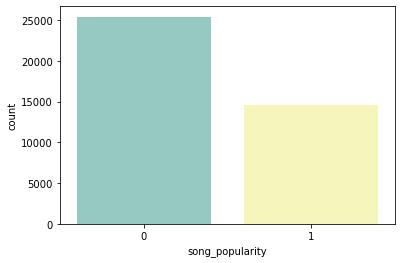

In [11]:
sns.countplot(train['song_popularity'], palette='Set3')

# Density plots of features

<Figure size 432x288 with 0 Axes>

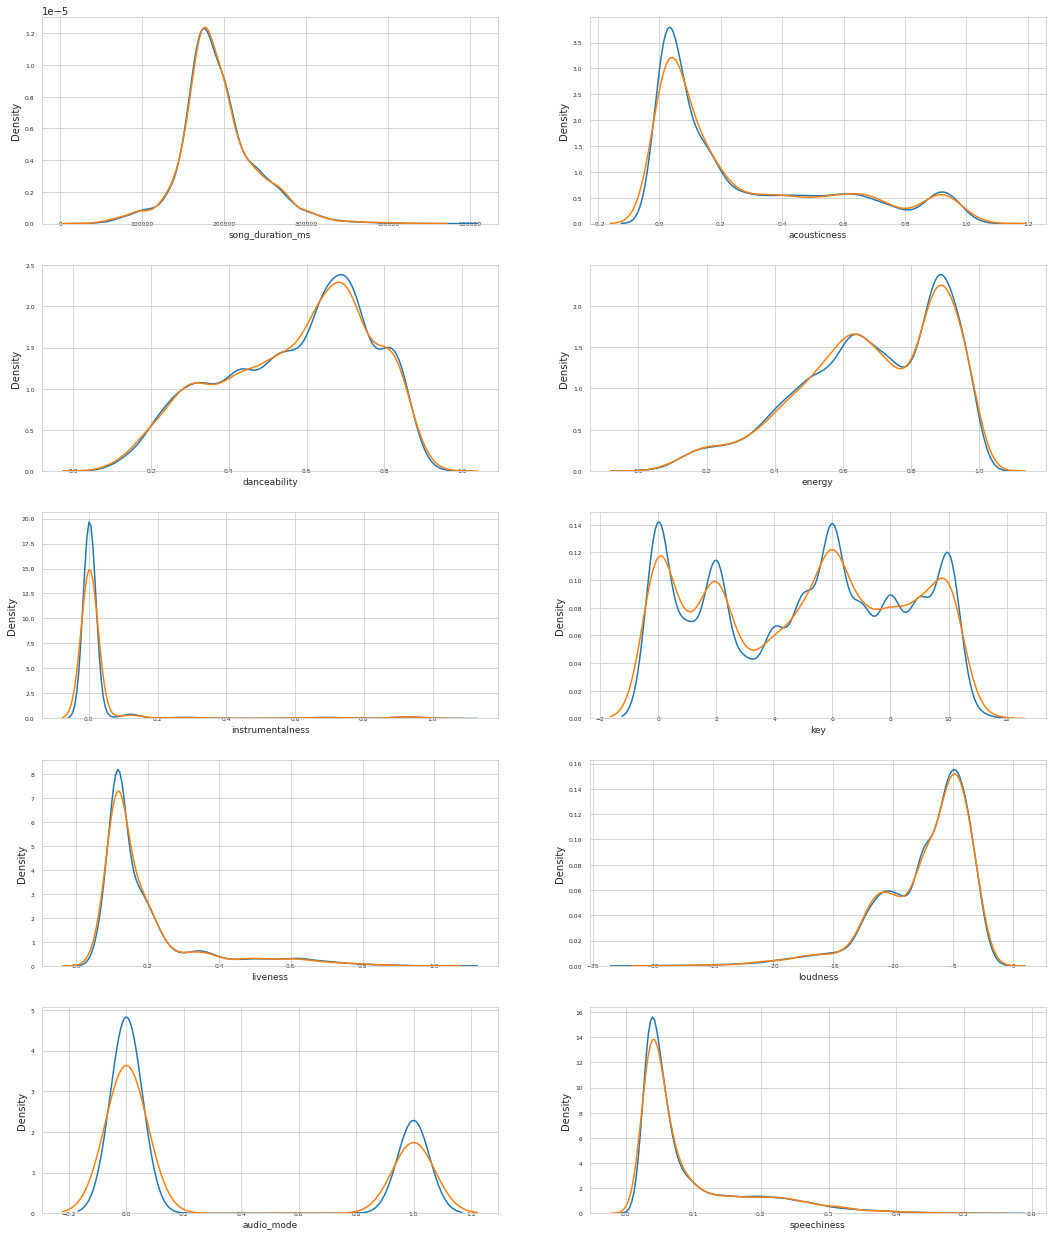

In [12]:
features = train.columns.values[0:10]
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(10,10,figsize=(18,22))

for feature in features:
    i += 1
    plt.subplot(5,2,i)
    sns.distplot(train[feature], hist=False,label='train')
    sns.distplot(test[feature], hist=False,label='test')
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
    plt.tick_params(axis='y', which='major', labelsize=6)
plt.show();

<Figure size 432x288 with 0 Axes>

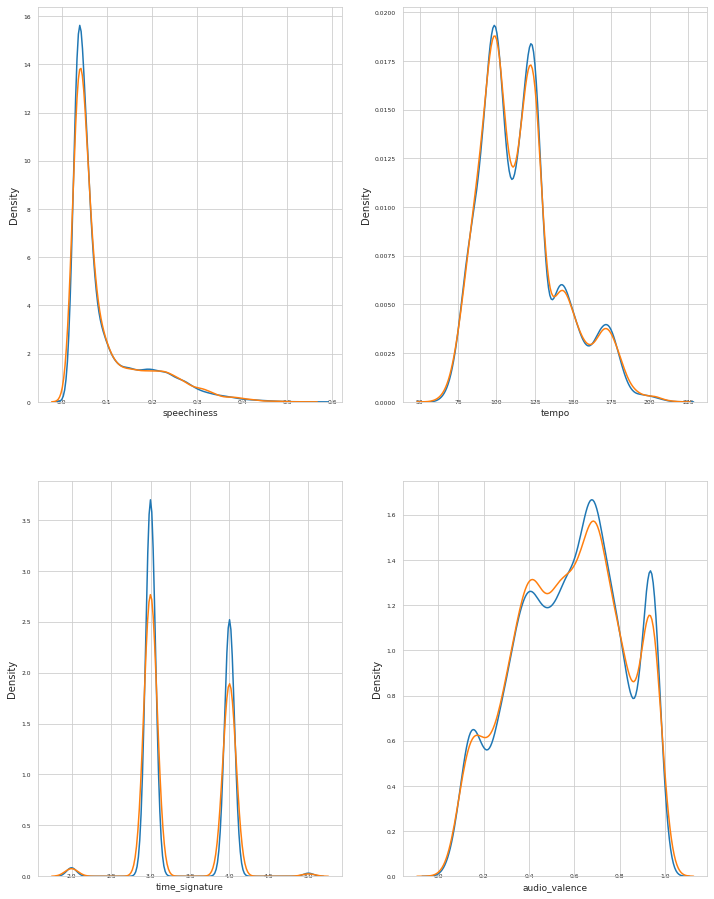

In [13]:
features = train.columns.values[9:13]
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(10,10,figsize=(12,16))

for feature in features:
    i += 1
    plt.subplot(2,2,i)
    sns.distplot(train[feature], hist=False,label='train')
    sns.distplot(test[feature], hist=False,label='test')
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
    plt.tick_params(axis='y', which='major', labelsize=6)
plt.show();

# Distribution of mean and std
This is the distribution of the mean values per row in the train and test set.

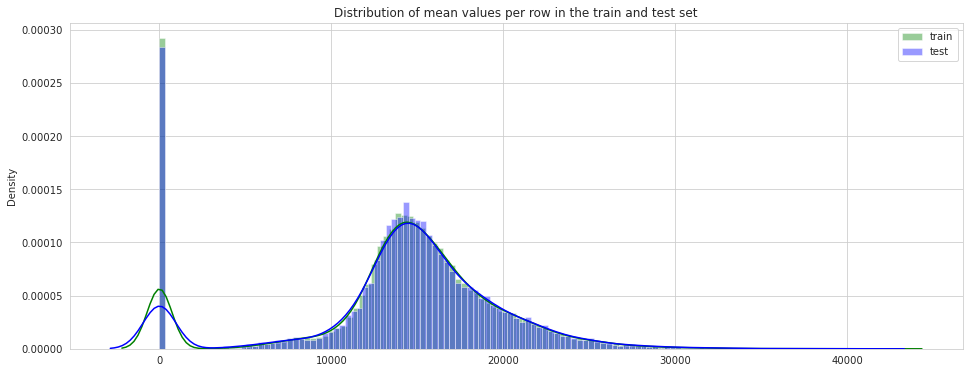

In [14]:
plt.figure(figsize=(16,6))
features = train.columns.values[0:13]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

Distribution of standard deviation of values per row for train and test datasets.

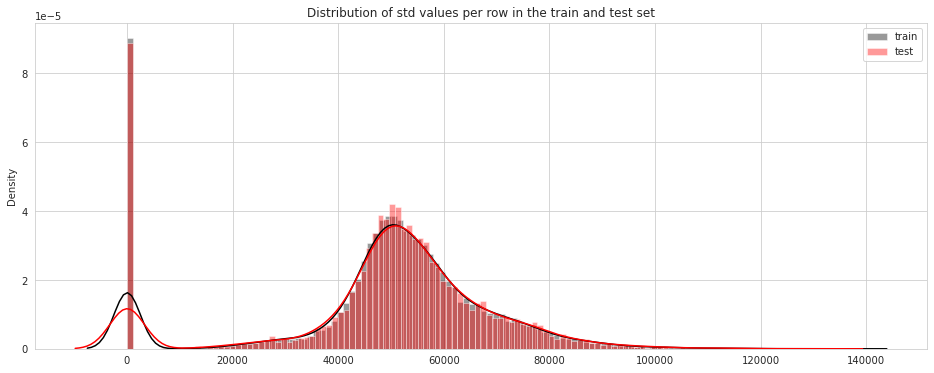

In [15]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

# Heatmap of correlation matrix

<AxesSubplot:>

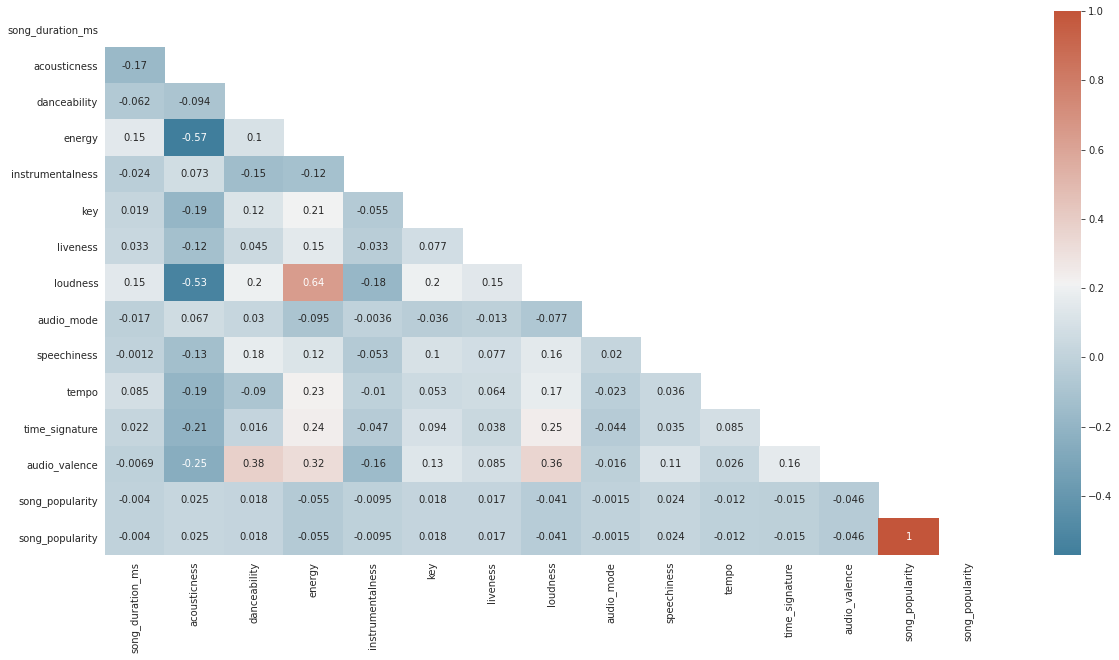

In [16]:
columns = train.columns[0:14].to_list()
columns.append('song_popularity')

corr = train[columns].corr()
f, ax = plt.subplots(figsize=(20,10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# Feature Engineering

In [17]:
X = train.drop('song_popularity', axis=1).copy()
y = train['song_popularity'].copy()
X_test = test.copy()

del train
gc.collect()
del test
gc.collect()

0

Here I am capturing NaN per row and making new feature

In [18]:
def feature_engineering(df):
    df['NaN_row'] = df.isna().sum(axis=1)
    df['std'] = df.std(axis=1)
    return df

X = feature_engineering(X)
X_test = feature_engineering(X_test)

In [19]:
X.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,NaN_row,std
0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.000000,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,1,59068.866047
1,NaN,0.054866,0.733289,0.835545,0.000996,8.000000,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1,28.391721
2,193213.000000,NaN,0.188387,0.783524,-0.002694,5.000000,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,1,53583.406352
3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.000000,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0,66784.131345
4,165969.000000,0.493017,NaN,0.740982,0.002033,10.000000,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,1,46028.378818


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
X_test = pd.DataFrame(columns=X_test.columns, data=pipeline.fit_transform(X_test))

In [21]:
X.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,NaN_row,std
0,0.456682,1.294390,1.584803,0.114664,-0.242534,1.550777,-0.000000,0.485958,-0.687808,-0.138019,1.598291,1.154896,0.648823,0.227218,0.570798
1,-0.000000,-0.783746,0.900914,0.751243,-0.249599,0.925135,1.655486,0.589785,1.453895,0.397799,-0.527746,-0.752053,0.551451,0.227218,-2.369403
2,0.001086,-0.000000,-2.123089,0.493477,-0.275518,-0.013328,-0.194938,0.667279,-0.687808,-0.500360,2.374043,-0.752053,-0.653509,0.227218,0.297623
3,1.306804,0.750905,0.079262,-0.650330,-0.252322,-1.577433,-0.721638,-0.132078,-0.687808,-0.699715,0.464423,-0.752053,-0.535282,-0.936065,0.955016
4,-0.626525,0.766319,0.000000,0.282681,-0.242311,1.550777,-0.721040,1.283428,-0.687808,-0.518729,0.205038,1.154896,0.676921,0.227218,-0.078615


# Model training & prediction

In [22]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [23]:
params = {  'objective': 'binary', 
            'n_estimators': 20000,
            'max_depth': 8,
            'learning_rate':  0.01, 
            'min_child_weight': 256,
            'min_child_samples': 15, 
            'reg_alpha': 10, 
            'reg_lambda': 0.1, 
            'subsample': 1, 
            'subsample_freq': 1, 
            'colsample_bytree': 0.4,}

In [24]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    model = LGBMClassifier(**params)
    
    model.fit(X_train, y_train,
              eval_set = [(X_valid, y_valid)],
              verbose = False,
              early_stopping_rounds = 300)
    
    pred_valid = model.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, pred_valid)
    score = auc(fpr, tpr)
    scores.append(score)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print('||'*40, "\n")
    
    test_preds = model.predict_proba(X_test)[:,1]
    preds.append(test_preds)
    
print(f"Overall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 0.5781653703182408

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 2 Score: 0.5711624168623627

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 3 Score: 0.5714868300914052

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 4 Score: 0.5833020030762579

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 5 Score: 0.5747216313262297

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 6 Score: 0.5884803342258831

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 7 Score: 0.5779494344127034

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 8 Score: 0.5759161046409349

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 9 Score: 0.5735805814848272

|||||||||||||||||||||

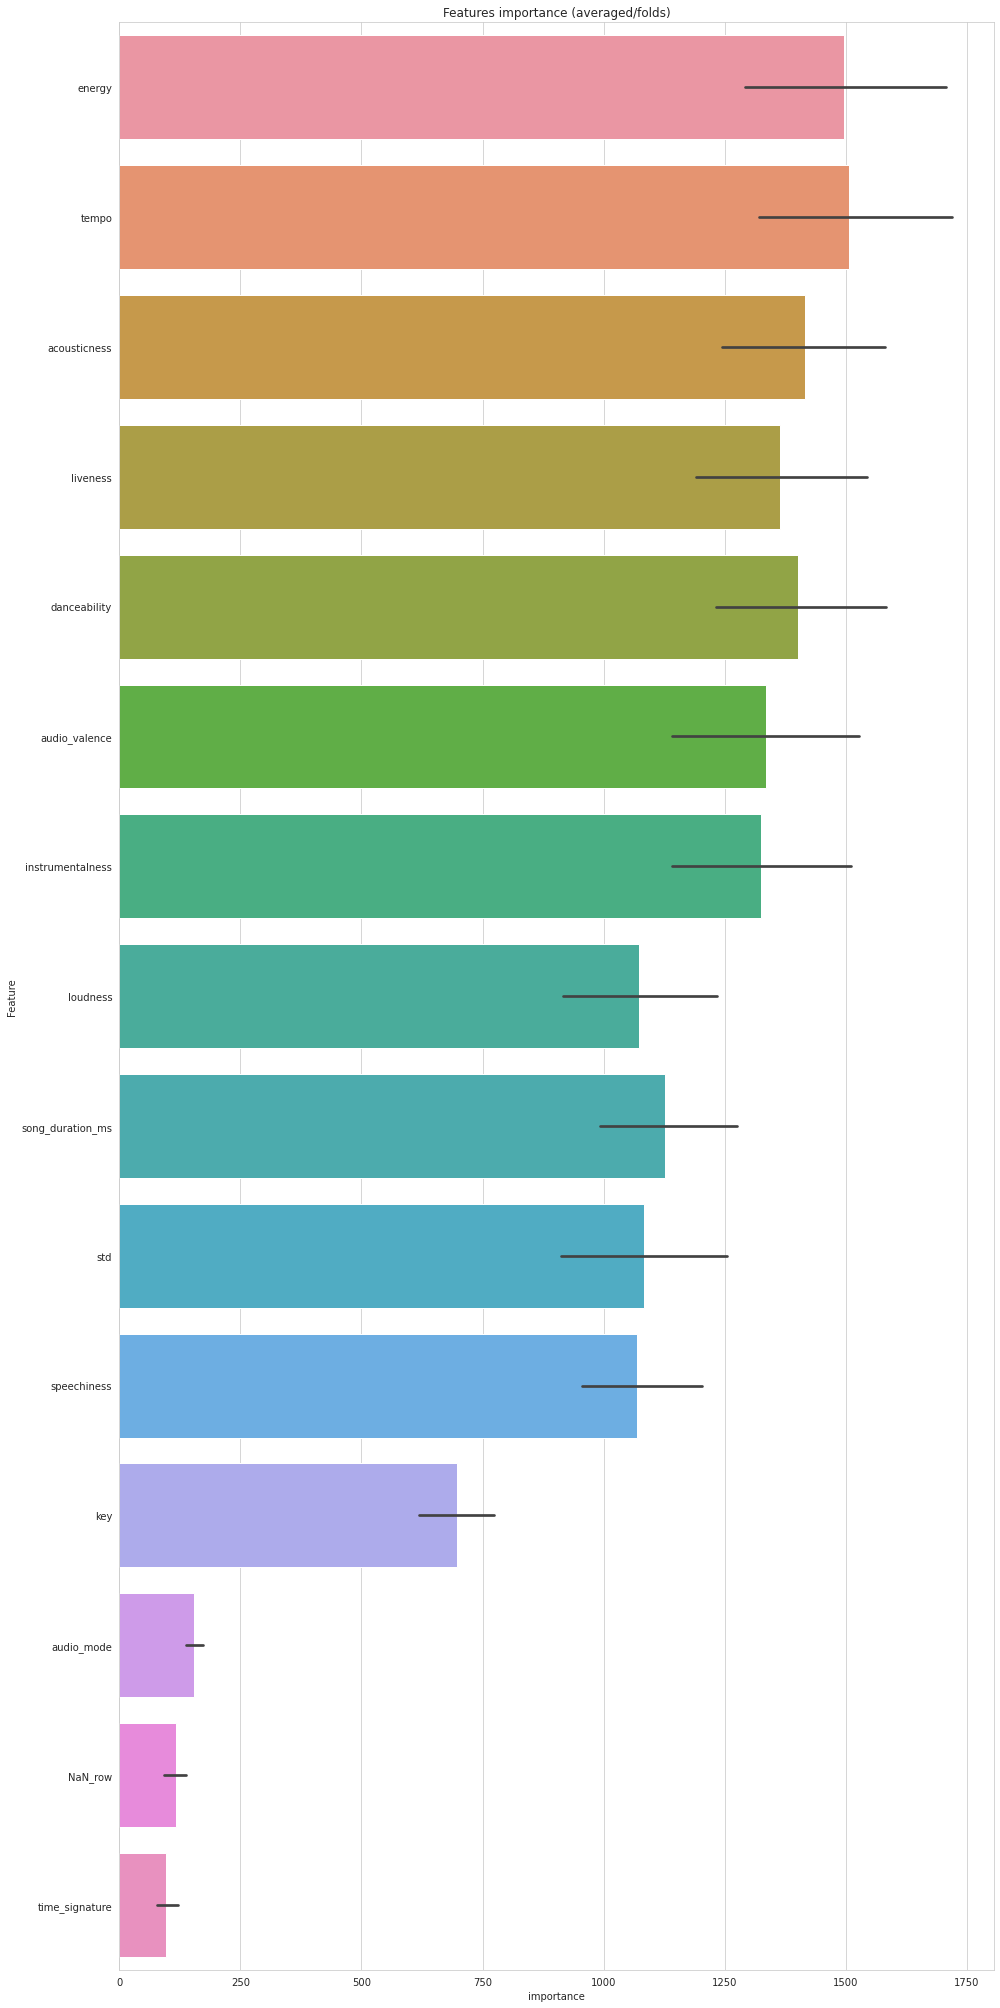

In [25]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:107].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [26]:
predictions = np.mean(np.column_stack(preds),axis=1)

ss['song_popularity'] = predictions
ss.to_csv('./lgbm.csv', index=False)
ss.head()

,id,song_popularity
0,0,0.418826
1,1,0.480260
2,2,0.288787
3,3,0.297767
4,4,0.363566


In [27]:
params = {  'objective': 'binary', 
            'n_estimators': 20000,
            'depth': 8,
            'learning_rate':  0.01, 
            #'min_child_weight': 256,
            'min_child_samples': 15,
            'reg_lambda': 0.1, 
            'subsample': 1, 
            'subsample_freq': 1, 
            'colsample_bytree': 0.4,}


In [30]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    model = CatBoostClassifier(verbose=False,n_estimators=1000,
                               learning_rate=0.01,depth=8,
                               iterations=1000,

                            )
    
    model.fit(X_train, y_train,
              eval_set = [(X_valid, y_valid)],
              verbose = False,
              early_stopping_rounds = 300)
    
    pred_valid = model.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, pred_valid)
    score = auc(fpr, tpr)
    scores.append(score)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print(f"Fold: {fold + 1} Score: {score}" " Catboost\n")
    print('||'*40, "\n")
    
    test_preds = model.predict_proba(X_test)[:,1]
    preds.append(test_preds)
    
print(f"Overall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 0.5822480649236698 Catboost

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 2 Score: 0.5724438761065338 Catboost

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 3 Score: 0.5730430419704892 Catboost

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 4 Score: 0.5831476234032028 Catboost

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 5 Score: 0.5770784699085542 Catboost

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 6 Score: 0.587636351273907 Catboost

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 7 Score: 0.5755637255695536 Catboost

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 

Fold: 8 Score: 0.5803918045154168 Catboost

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [31]:
predictions = np.mean(np.column_stack(preds),axis=1)

ss['song_popularity'] = predictions
ss.to_csv('./catb.csv', index=False)
ss.head()

,id,song_popularity
0,0,0.370234
1,1,0.473705
2,2,0.250843
3,3,0.321821
4,4,0.371389
